# TEBD for a Spin-Boson model on different Tree Structures
We will consider a spin-boson model where for a chain of $N$ interacting spins each spin-system couples to $M$ different bosonic systems. This model is described by the Hamiltonian
$$
H = H_S + H_B + H_I,
$$
where
$$
H_S = -J \sum_{s=0}^{N-2} X_s X_{s+1}
$$
$$
H_B = \sum_{s,b=0}^{N-1,M-1} \frac{m_{s,b} \omega_{s,b}}{2} \mathcal{N}_{s,b}
$$
$$
H_I = \sum_{s,b=0}^{N-1,M-1} g_{s,b} Z_s (a_{s,b}^\dagger + a_{s,b}).
$$
Here $X, Z$ are Pauli operators, $a^\dagger$ and $a$ are the bosonic creation and annihilation operators, $\mathcal{N}$ the number operator, $g$ the interaction strength between spin and boson systems, and $m$ and $\omega$ the mass and characteristic frequency of a bosonic system respectively.

In [1]:
# Import PyTreeNet from local folders
import sys
sys.path.append('..')
import pytreenet as ptn
from pytreenet.special_ttn.fttn import ForkTreeProductState

import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import expm
from copy import deepcopy

## Initialising the TEBD
We want to run the algorithm for two different tree patterns connecting each spin to its respective bosons. To make the computation numerically possible, we have to set a maximun physical dimension of the bosonic system $d_{\text{max}}$. The initial state of the simulation will be |0> for all spins and the ground state for the bosonic systems.

In [2]:
# Constants needed for both trees
num_spins = 2
num_bosons_per_spin = 1

boson_dimension = 3

spin_initial_state = np.asarray([1,0], dtype=complex)
boson_initial_state = np.zeros(boson_dimension, dtype=complex)
boson_initial_state[0] = 1

print(f"Initial spin state: {spin_initial_state}")
print(f"Initial bosonic state: {boson_initial_state}")

Initial spin state: [1.+0.j 0.+0.j]
Initial bosonic state: [1.+0.j 0.+0.j 0.+0.j]


In [3]:
# We can also initialise dictionaries representing the operators in the Hamiltonian
# For now we assume all constants for every bosonic system to be the same
momega = 3
g = 0.5
mJ = -2

X, _, Z = ptn.pauli_matrices()

creation_op, annihilation_op, number_op = ptn.bosonic_operators(dimension=boson_dimension)

hamiltonian_operators = []

# Spin interaction operators
for s in range(num_spins - 1):
    interaction_operator = {"spin" + str(s): mJ*X}
    interaction_operator["spin" + str(s+1)] = X
    hamiltonian_operators.append(ptn.TensorProduct(interaction_operator))
    
# Bosonic operators
for s in range(num_spins):
    for b in range(num_bosons_per_spin):
        bosonic_operator = {"boson" + str(s) + "_" + str(b): (momega / 2) * number_op}
        hamiltonian_operators.append(ptn.TensorProduct(bosonic_operator))
        
# Spin-Boson interaction operators
for s in range(num_spins):
    for b in range(num_bosons_per_spin):
        interaction_operator = {"spin" + str(s): g * Z}
        interaction_operator["boson" + str(s) + "_" + str(b)] = (creation_op + annihilation_op)
        hamiltonian_operators.append(ptn.TensorProduct(interaction_operator))

### Star Tree Structure
In the first structure we will initialise each boson is directly connected to its initial spin, making it look like a star. Additionally, the spins are interconnected.

In [4]:
# Leg convention of spin tensor:
# (left spin neighbour)-(legs to bosons)-(right spin neighbour)-(physical leg)
spin_tensor_shape = (2 + num_bosons_per_spin) * [1]
spin_tensor_shape.append(2)
spin_tensor_shape = tuple(spin_tensor_shape)

# Leg convention to initialise bosonic tensor:
# (leg to spin)-(physical leg)
boson_tensor_shape = (1, boson_dimension)

# Reshaping initial states by adding trivial (i.e. one-dimensional) legs
initial_spin_tensor = spin_initial_state.reshape(spin_tensor_shape)
initial_boson_tensor = boson_initial_state.reshape(boson_tensor_shape)

# Building the TTN
star_tree_network = ptn.TreeTensorNetworkState()

for s in range(num_spins):
    spin_node_identifier = "spin" + str(s)
    if s == 0:
        spin_node = ptn.Node(identifier=spin_node_identifier)
        tensor = deepcopy(initial_spin_tensor[0])
        num_legs_before_boson_legs = 0
    elif s == num_spins - 1:
        spin_node = ptn.Node(identifier=spin_node_identifier)
        tensor = deepcopy(initial_spin_tensor[:,0]) # It does not matter which of the legs we cut out
        num_legs_before_boson_legs = 1
    else:
        spin_node = ptn.Node(identifier=spin_node_identifier)
        tensor = deepcopy(initial_spin_tensor)
        num_legs_before_boson_legs = 1
        
    if s == 0:
        star_tree_network.add_root(spin_node, tensor)
    elif s == 1:
        spin_parent_identifier = "spin0"
        star_tree_network.add_child_to_parent(spin_node, tensor, 0, spin_parent_identifier, 0 + num_bosons_per_spin)
    else:
        spin_parent_identifier = "spin" + str(s-1)
        star_tree_network.add_child_to_parent(spin_node, tensor, 0, spin_parent_identifier, 1 + num_bosons_per_spin)
    
    # Attaching boson nodes to each spin
    for b in range(num_bosons_per_spin):
        boson_node_identifier = "boson" + str(s) + "_" + str(b)
        boson_node = ptn.Node(identifier=boson_node_identifier)
        tensor = deepcopy(initial_boson_tensor)
        star_tree_network.add_child_to_parent(boson_node, tensor, 0, spin_node_identifier, num_legs_before_boson_legs + b)

### Fork Tree Structure
In the second structure each spin node has a chain of bosonic nodes attached to it, while at being connected to its spin neighbours too.

In [5]:
# Leg convention for spin tensor:
# (left spin neighbour)-(legs to bosons)-(right spin neighbour)-(physical leg)
spin_tensor_shape = [1,1,1,2]

# Leg convention for bosonic tensor:
# (leg to spin/left neighbour)-(leg to right neighbour)-(physical leg)
boson_tensor_shape = [1, 1, boson_dimension]

# Reshaping initial tensor into correct shape using trivial legs
initial_spin_tensor = spin_initial_state.reshape(spin_tensor_shape)
initial_boson_tensor = boson_initial_state.reshape(boson_tensor_shape)

# Build TTN
fork_tree_network = ForkTreeProductState(main_identifier_prefix="spin",
                                         subchain_identifier_prefix="boson")

for spin in range(num_spins):
    if spin == 0:
        tensor = deepcopy(initial_spin_tensor[0])
    elif spin == num_spins - 1:
        tensor = deepcopy(initial_spin_tensor[:,:,0,:])
    else:
        tensor = deepcopy(initial_spin_tensor)
    fork_tree_network.add_main_chain_node(tensor)

    for boson in range(num_bosons_per_spin):
        if boson == num_bosons_per_spin - 1:
            tensor = deepcopy(initial_boson_tensor[:,0,:])
        else:
            tensor = deepcopy(initial_boson_tensor)
        fork_tree_network.add_sub_chain_node(tensor, spin)

In [6]:
print(f"Tensors in main chain: {fork_tree_network.main_length()}")
print(f"Tensors in the chains: {[fork_tree_network.subchain_length(i) for i in range(num_spins)]}")

Tensors in main chain: 2
Tensors in the chains: [1, 1]


## Trotter Splitting
As a next step, we have to decide how to split up the time-evolution using a Trotter splitting. These are different for both structures and have a considerable effect on the performance. To keep the two different cases comparable, we will use a simple first order Trotter-Suzuki splitting for both:
$$
e^{-i \delta t H} \approx e^{-i \delta t H_I} e^{-i \delta t H_B} e^{-i \delta t H_S}.
$$

### Trotter Splitting for Star Structure

In [7]:
# First we have to collect their indices with which the operator are saved in the hamiltonian_operator list.
# We were smart with our list, such that it is exactly in the desired order.
# Thus we can initialise the trotter_splitting directly.
splitting_star_structure = ptn.TrotterSplitting(hamiltonian_operators)

### Trotter Splitting for Fork Structure
In this case the splitting is not as trivial. Some of the operators we put in `hamiltonian_operators` are not between neighbouring sites. Therefore, we will have to insert corresponding SWAP gates that make the total interaction a nearest neighbour interaction. This also includes relabelling some of the operators.

In [8]:
# Relabelling: All spin-boson operators will be between the spin node and its neighbouring boson node.
# By using appropriate SWAP gates, this can be made equivalent to the original evolution.
max_index_of_non_interaction_operators = num_spins - 1 + num_spins * num_bosons_per_spin
fork_hamiltonian_operators = hamiltonian_operators[0:max_index_of_non_interaction_operators]

for s in range(num_spins):
    spin_identifier = "spin" + str(s)
    boson_identifier = "boson" + str(s) + "_0"
    
    for b in range(num_bosons_per_spin):
        interaction_operator = {spin_identifier: g * Z}
        interaction_operator[boson_identifier] = (creation_op + annihilation_op)
        fork_hamiltonian_operators.append(ptn.TensorProduct(interaction_operator))
    
# Now we need to add the SWAP gates
swaps_before = [ptn.SWAPlist([]) for i in range(max_index_of_non_interaction_operators)]
swaps_after = [ptn.SWAPlist([]) for i in range(max_index_of_non_interaction_operators)]

for s in range(num_spins):
    for b in range(num_bosons_per_spin):
        swaps = []
        for b_chain in range(1, b+1):
            swaps.append(("boson" + str(s) + "_" + str(b_chain - 1),"boson" + str(s) + "_" + str(b_chain)))
        
        swaps_after.append(ptn.SWAPlist(swaps))
        swaps.reverse()
        swaps_before.append(ptn.SWAPlist(swaps))
        
# Construct Trotter Splitting
splitting_fork_structure = ptn.TrotterSplitting(fork_hamiltonian_operators, 
                                                swaps_before=swaps_before, 
                                                swaps_after=swaps_after)

## The TEBD-algorithm
Now it is finally time to initialise and create the two TEBD simulations.

In [9]:
# Constants
time_step_size = 0.001
final_time = 0.1
max_bond_dim = 10

# We want to explore a variety of quantities:
# The local magnetisation
operators = [ptn.TensorProduct({("spin" + str(s)): Z}) for s in range(num_spins)]

# The total magnetisation
operators.append(ptn.TensorProduct({("spin" + str(s)): Z for s in range(num_spins)}))

# The boson number at each bosonic site
for s in range(num_spins):
    operators.extend([{"boson" + str(s) + "_" + str(b): number_op} for b in range(num_bosons_per_spin)])
    
# Initialising TEBDs
star_TEBD = ptn.TEBD(deepcopy(star_tree_network), splitting_star_structure, time_step_size, final_time,
                    operators=operators, max_bond_dim=max_bond_dim)
fork_TEBD = ptn.TEBD(deepcopy(fork_tree_network), splitting_fork_structure, time_step_size, final_time,
                    operators=operators, max_bond_dim=max_bond_dim)

In [10]:
star_TEBD.run()
fork_TEBD.run()

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:00<00:00, 283.34it/s]


## Running the reference matrix vector computation
For this small of a system we can still run an exact time-evolution.

In [11]:
spin_initial_state = np.asarray([1,0], dtype=complex)
boson_initial_state = np.zeros(boson_dimension, dtype=complex)
boson_initial_state[0] = 1

ref_state = 1
for s in range(num_spins):
    ref_state = np.kron(ref_state, spin_initial_state)

    for b in range(num_bosons_per_spin):
        ref_state = np.kron(ref_state, boson_initial_state)

print(f"The initial state has {ref_state.shape[0]} entries.")

The initial state has 36 entries.


In [12]:
hamiltonian = np.zeros((ref_state.shape[0], ref_state.shape[0]), dtype=complex)

# Spin interaction
for s in range(num_spins - 1):
    operator = 1
    for s2 in range(num_spins):
        if s2 == s:
            operator = np.kron(operator, mJ * X)
        elif s2 == s + 1:
            operator = np.kron(operator, X)
        else:
            operator = np.kron(operator, np.eye(2))
        for b in range(num_bosons_per_spin):
            operator = np.kron(operator, np.eye(boson_dimension))
    hamiltonian += operator

# Boson single site
for s in range(num_spins):
    for b in range(num_bosons_per_spin):
        operator = 1
        for s2 in range(num_spins):
            operator = np.kron(operator, np.eye(2))
            for b2 in range(num_bosons_per_spin):
                if s2 == s and b2 == b:
                    operator = np.kron(operator, (momega / 2) * number_op)
                else:
                    operator = np.kron(operator, np.eye(boson_dimension))
        hamiltonian += operator

# Spin-Boson interaction
for s in range(num_spins):
    for b in range(num_bosons_per_spin):
        operator = 1
        for s2 in range(num_spins):
            if s2 == s:
                operator = np.kron(operator, g * Z)
            else:
                operator = np.kron(operator, np.eye(2))
            for b2 in range(num_bosons_per_spin):
                if s2 == s and b2 == b:
                    operator = np.kron(operator, (creation_op + annihilation_op))
                else:
                    operator = np.kron(operator, np.eye(boson_dimension))
        hamiltonian += operator

print(f"The Hamiltonian has a shape of {hamiltonian.shape}. Thus it has {np.prod(hamiltonian.shape)} entries.")

The Hamiltonian has a shape of (36, 36). Thus it has 1296 entries.


In [13]:
exp_operator = expm(-1j*time_step_size*hamiltonian)

In [14]:
ref_operators = []

# Total Magnetisation
operator = 1
for s in range(num_spins):
    operator = np.kron(operator, Z)
    for b in range(num_bosons_per_spin):
        operator = np.kron(operator, np.eye(boson_dimension))
ref_operators.append(operator)

# Boson numbers
for s in range(num_spins):
    for b in range(num_bosons_per_spin):
        operator = 1
        for s2 in range(num_spins):
            operator = np.kron(operator, np.eye(2))
            for b2 in range(num_bosons_per_spin):
                if s2 == s and b2 == b:
                    operator = np.kron(operator, number_op)
                else:
                    operator = np.kron(operator, np.eye(boson_dimension))
        ref_operators.append(operator)            


In [15]:
num_time_steps = int(np.ceil(final_time / time_step_size))
results = np.zeros((len(ref_operators) + 1, num_time_steps + 1), dtype=complex)
init_ref_state = deepcopy(ref_state)

for time_step in range(num_time_steps + 1):
    if time_step != 0:
        ref_state = exp_operator @ ref_state
    
    conj_state = np.conjugate(ref_state.T)
    for i, operator in enumerate(ref_operators):
        results[i,time_step] = conj_state @ operator @ ref_state
        
    results[-1,time_step] = time_step * time_step_size
    
results.shape

(4, 101)

# Plotting Results

In [16]:
times = [time.real for time in star_TEBD.results[-1]]

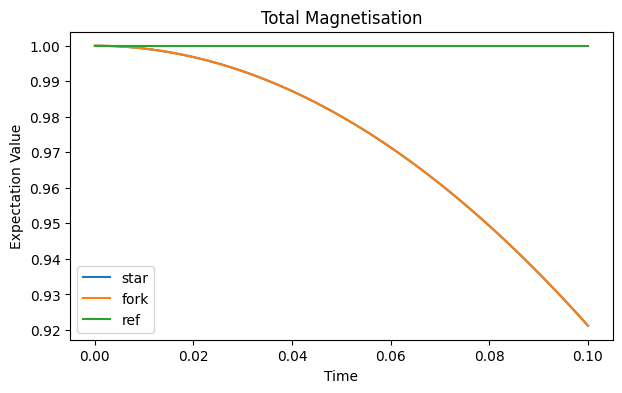

In [24]:
fig = plt.figure(figsize=(7,4))

plt.plot(times, [exp_val.real for exp_val in star_TEBD.results[0]], label="star")
plt.plot(times, [exp_val.real for exp_val in fork_TEBD.results[0]], label="fork")
plt.plot(times, [exp_val.real for exp_val in results[0]], label="ref")

plt.title("Total Magnetisation")
plt.xlabel("Time")
plt.ylabel("Expectation Value")

plt.legend()

plt.show()

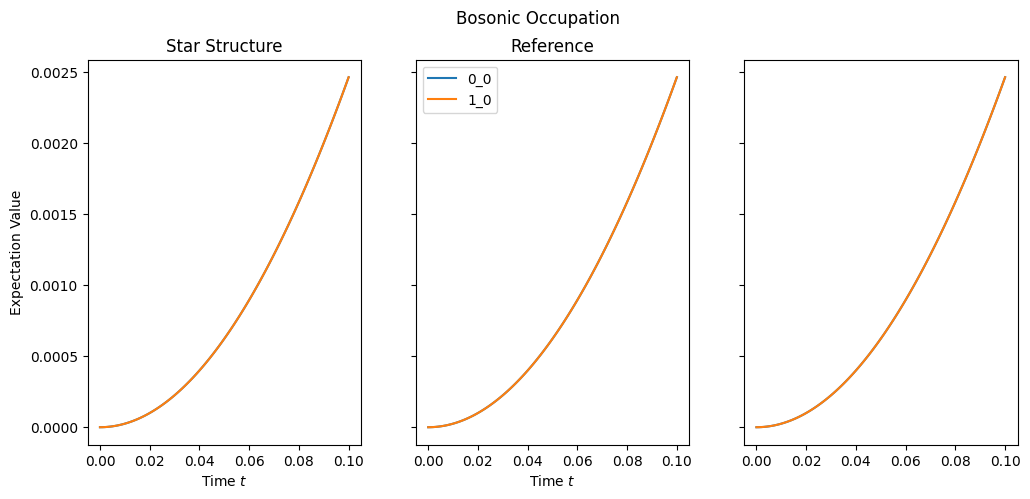

In [22]:
fig2, ax2 = plt.subplots( 1, 3, figsize=(12,5), sharey=True)
fig2.suptitle("Bosonic Occupation")

for s in range(num_spins):
    for b in range(num_bosons_per_spin):
        ax2[0].plot(times, [exp_val.real for exp_val in star_TEBD.results[1+num_spins+s*num_bosons_per_spin+b]])
        ax2[1].plot(times, [exp_val.real for exp_val in fork_TEBD.results[1+num_spins+s*num_bosons_per_spin+b]],
                   label=(str(s)+ "_" + str(b)))
        ax2[2].plot(times, [exp_val.real for exp_val in results[1+s*num_bosons_per_spin+b]],
                   label=(str(s)+ "_" + str(b)))

ax2[1].legend()
        
ax2[0].set_xlabel("Time $t$")
ax2[0].set_ylabel("Expectation Value")
ax2[0].set_title("Star Structure")
        
ax2[1].set_xlabel("Time $t$")
ax2[1].set_title("Fork Structure")

ax2[1].set_xlabel("Time $t$")
ax2[1].set_title("Reference")

plt.show()

We can clearly see a difference between the two, since we used an equivalent splitting of the Hamiltonian for both systems, it is likely that the difference comes from truncating the bond dimension. We can easily check the convergence for different maximum bond dimensions.

# Benchmarking the Error
## Bond-Dimension

In [19]:
max_bond_list = [1,2,3,4,5,8,10,12,15,20,25]
star_tebds = []
fork_tebds = []

for max_bond_dim in max_bond_list:
    star_TEBD_temp = ptn.TEBD(deepcopy(star_tree_network), splitting_star_structure, time_step_size, final_time,
                                operators=operators, max_bond_dim=max_bond_dim)
    fork_TEBD_temp = ptn.TEBD(deepcopy(fork_tree_network), splitting_fork_structure, time_step_size, final_time,
                                operators=operators, max_bond_dim=max_bond_dim)
    
    print(f"Maximum bond dimension = {max_bond_dim}")
    star_TEBD_temp.run()
    fork_TEBD_temp.run()
    
    star_tebds.append(star_TEBD_temp)
    fork_tebds.append(fork_TEBD_temp)

Maximum bond dimension = 1


100%|██████████| 101/101 [00:00<00:00, 298.10it/s]


Maximum bond dimension = 2


100%|██████████| 101/101 [00:00<00:00, 290.53it/s]


Maximum bond dimension = 3


100%|██████████| 101/101 [00:00<00:00, 301.33it/s]


Maximum bond dimension = 4


100%|██████████| 101/101 [00:00<00:00, 341.16it/s]


Maximum bond dimension = 5


100%|██████████| 101/101 [00:00<00:00, 338.77it/s]


Maximum bond dimension = 8


100%|██████████| 101/101 [00:00<00:00, 337.09it/s]


Maximum bond dimension = 10


100%|██████████| 101/101 [00:00<00:00, 339.94it/s]


Maximum bond dimension = 12


100%|██████████| 101/101 [00:00<00:00, 339.36it/s]


Maximum bond dimension = 15


100%|██████████| 101/101 [00:00<00:00, 339.47it/s]


Maximum bond dimension = 20


100%|██████████| 101/101 [00:00<00:00, 337.30it/s]


Maximum bond dimension = 25


100%|██████████| 101/101 [00:00<00:00, 339.34it/s]


IndexError: index 6 is out of bounds for axis 0 with size 6

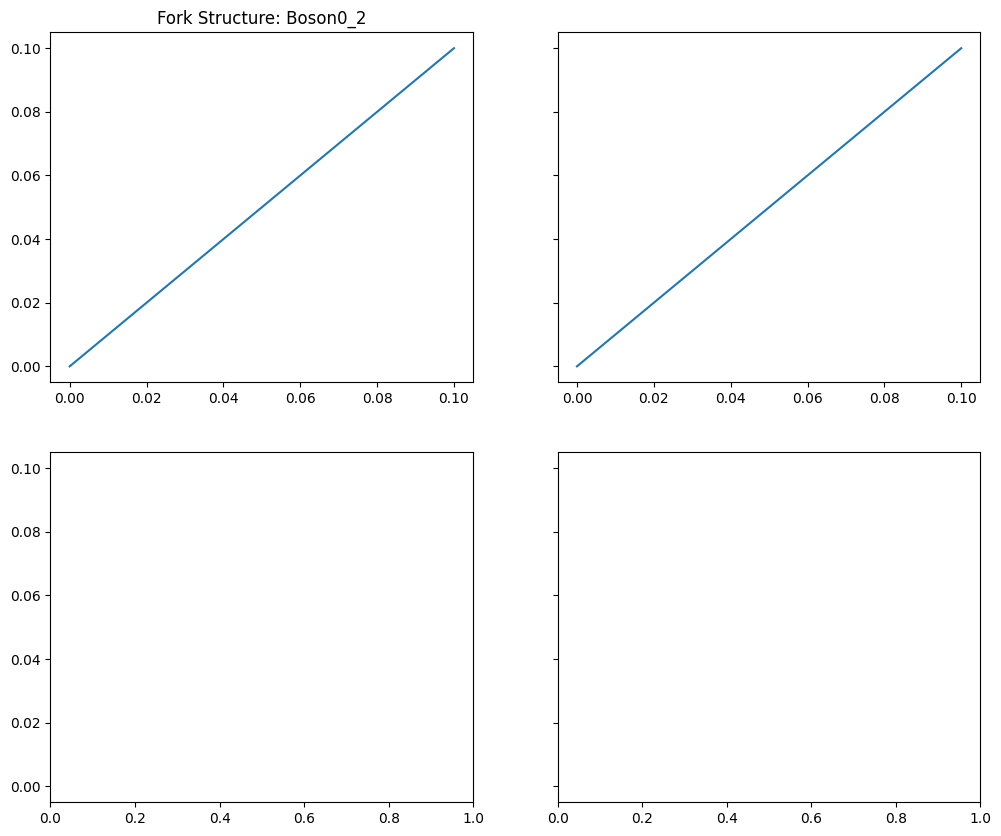

In [20]:
times = [time.real for time in star_tebds[0].results[-1]]

fig3, ax3 = plt.subplots(2,2, sharey=True, figsize=(12,10))

for i, max_bond in enumerate(max_bond_list):
        
        #Choose any of the Bosons
        b = 2
        for s in range(num_spins):
            ax3[s,0].plot(times, [exp_val.real for exp_val in star_tebds[i].results[1+num_spins+s*num_bosons_per_spin+b]],
                           label=f"max_bond={max_bond}")
            ax3[s,1].plot(times, [exp_val.real for exp_val in fork_tebds[i].results[1+num_spins+s*num_bosons_per_spin+b]],
                           label=f"max_bond={max_bond}")
            
            ax3[s,0].set_title(f"Star Structure: Boson{s}_{b}")
            ax3[s,0].set_title(f"Fork Structure: Boson{s}_{b}")
            
for ax in ax3.flatten():
    ax.legend()

In [ ]:
def extract_bond_dim(tebd_list):
    """
    Extracts some information about the bond dimension of the tensor state of all tebds in the tebd_list
    """
    total_num_of_elements_list = []
    actual_max_bond_list = []
    
    for tebd in tebd_list:
        total_num_of_elements = 0
        actual_max_bond = 0

        for node in tebd.state.nodes.values():
            shape = node.shape
            # Check for maximum bond_dim
            shape_virtual = [shape[leg_index] for leg_index in range(node.nvirt_legs())]
            max_shape = max(shape_virtual)
            if actual_max_bond < max_shape:
                actual_max_bond = max_shape

            # Find total number of elements in this tensor
            elements_in_this_tensor = 1
            for dim in shape:
                elements_in_this_tensor *= dim
            total_num_of_elements += elements_in_this_tensor

        total_num_of_elements_list.append(total_num_of_elements)
        actual_max_bond_list.append(actual_max_bond)
        
    return total_num_of_elements_list, actual_max_bond_list    

We can clearly see that the star structure converges faster, but also takes much longer to compute, than the fork structure. To investigate a little further, we will look at the bond-dimensions of the stats after the time-evolution.

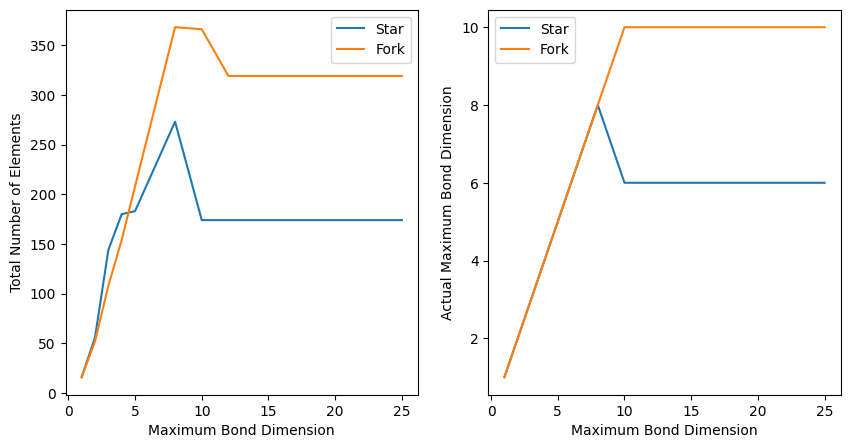

In [ ]:
star_num_of_elements_list, star_actual_max_bond_list = extract_bond_dim(star_tebds)
fork_num_of_elements_list, fork_actual_max_bond_list = extract_bond_dim(fork_tebds)

fig4, ax4 = plt.subplots(1, 2, figsize=(10,5))

ax4[0].plot(max_bond_list, star_num_of_elements_list, label="Star")
ax4[0].plot(max_bond_list, fork_num_of_elements_list, label="Fork")
ax4[0].set_ylabel("Total Number of Elements")
ax4[0].set_xlabel("Maximum Bond Dimension")
ax4[0].legend()

ax4[1].plot(max_bond_list, star_actual_max_bond_list, label="Star")
ax4[1].plot(max_bond_list, fork_actual_max_bond_list, label="Fork")
ax4[1].set_xlabel("Maximum Bond Dimension")
ax4[1].set_ylabel("Actual Maximum Bond Dimension")
ax4[1].legend()

plt.show()

## Error Scaling with Time-Step
According to our splitting the error should scale as $\text{err} \propto \delta t$.

In [ ]:
final_time = 1
errors = []
ref_exp_op = expm(-1j*final_time*hamiltonian)
new_ref_state = deepcopy(init_ref_state)
final_ref_state = exp_operator @ new_ref_state
conj_state = np.conjugate(final_ref_state.T)
ref_result = conj_state @ ref_operators[0] @ new_ref_state

time_steps = np.arange(0.01,0.2,0.01)
for time_step in time_steps:
    tebd = ptn.TEBD(deepcopy(fork_tree_network), splitting_fork_structure,
                    time_step, final_time, operators[num_spins],
                    max_bond_dim=11)
    tebd.run(pgbar=False)

    error = np.abs(tebd.results[0,-1] - ref_result)
    errors.append(error)

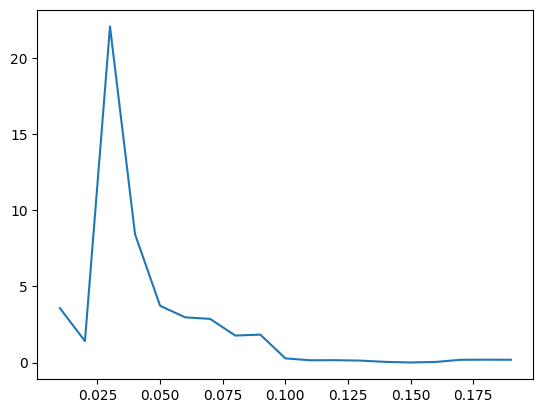

In [ ]:
fig_time_err = plt.figure()

plt.plot(list(time_steps), errors)
plt.show()